In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# pip install openpyxl
# pip install lifeines

# Load the Excel file and convert to CSV
df = pd.read_excel("../Data/RADCURE_Clinical_v04_20241219.xlsx")  # Use 'openpyxl' for .xlsx files
df.to_csv("../Data/RADCURE_Clinical_v04_20241219.csv", index=False)  # index=False prevents adding an extra index column
print(f"Excel file 'RADCURE_Clinical_v04_20241219.xlsx' converted to CSV as 'RADCURE_Clinical_v04_20241219.csv'")



# 1. Load the dataset
cancer_clinical_cia = pd.read_csv('../Data/RADCURE_Clinical_v04_20241219.csv') # Head and Neck cancer clinical data from the Cancer Imaging Archive

# 2. Examine the Dataset: Investigate the dataset before cleaning to find NA values, duplicates, etc.
print(cancer_clinical_cia.head()) 
cancer_clinical_cia.info() # columns 24-31 have a high number of NA values
print(cancer_clinical_cia.shape) #dimensions
# print(cancer_clinical_cia.describe()) # mean age is ~60
# cancer_clinical_cia.tail()
# print(cancer_clinical_cia.columns)
# cancer_clinical_cia.dtypes # dtypes: float64(3), int64(2), object(29)



print(cancer_clinical_cia.isnull().sum())  # Missing values

# plot to understand dataset key features
# sns.histplot(df["Age"], bins=20, kde=True)
# plt.title("Age Distribution")
# plt.show()

# sns.countplot(x="Stage", data=df)
# plt.title("Tumor Stage Distribution")
# plt.show()

# sns.countplot(x="Tx Modality", data=df)
# plt.title("Treatment Type Distribution")
# plt.show()


# Subset of the relevant columns for the analysis
relevant_columns = ['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Stage', 'Tx Modality', 'Status' ,'Length FU']
df_subset = cancer_clinical_cia[relevant_columns].copy()

# Fixing the warning and handling missing values:
# Convert 'Smoking PY' to numeric, forcing errors to NaN
df_subset.loc[:, 'Smoking PY'] = pd.to_numeric(df_subset['Smoking PY'], errors='coerce')
# Fill missing values with the median of the column
df_subset.loc[:, 'Smoking PY'] = df_subset['Smoking PY'].fillna(df_subset['Smoking PY'].median())
df_subset = df_subset.infer_objects() # To address FutureWarningErrors downcasting errors

# For 'ECOG PS', fill missing values with the mode
df_subset.loc[:, 'ECOG PS'] = df_subset['ECOG PS'].fillna(df_subset['ECOG PS'].mode()[0])
df_subset.loc[:, 'ECOG PS'] = df_subset['ECOG PS'].fillna(df_subset['ECOG PS'].mode().iloc[0] if not df_subset['ECOG PS'].mode().empty else 0)


# Event indicator based on 'Status' column (1 = event, 0 = censored)
df_subset['Status'] = df_subset['Status'].str.strip()
df_subset.loc[:, 'Event'] = df_subset['Status'].apply(lambda x: 1 if x == 'Dead' else 0)
# Survival time (e.g., 'Length FU' or the time between 'Date of Death' and 'Last FU')
df_subset.loc[:, 'Survival_Time'] = df_subset['Length FU']

# Handling missing values and checking data types
print(df_subset.dtypes)  # This will show data types after fixes




# # Convert categorical variables to numeric using OneHotEncoding
# cat_cols = df.select_dtypes(include=['object']).columns
# df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


print(df_subset.head())


Excel file 'RADCURE_Clinical_v04_20241219.xlsx' converted to CSV as 'RADCURE_Clinical_v04_20241219.csv'
     patient_id   Age     Sex ECOG PS Smoking PY Smoking Status     Ds Site  \
0  RADCURE-0005  62.6  Female  ECOG 0         50      Ex-smoker  Oropharynx   
1  RADCURE-0006  87.3    Male  ECOG 2         25      Ex-smoker      Larynx   
2  RADCURE-0007  49.9    Male  ECOG 1         15      Ex-smoker  Oropharynx   
3  RADCURE-0009  72.3    Male  ECOG 1         30      Ex-smoker     Unknown   
4  RADCURE-0010  59.7  Female  ECOG 0          0     Non-smoker  Oropharynx   

           Subsite    T    N  ... Local Date Local Regional Date Regional  \
0        post wall  T4b  N2c  ...   NaN        NaN      NaN           NaN   
1          Glottis  T1b   N0  ...   NaN        NaN      NaN           NaN   
2           Tonsil   T3  N2b  ...   NaN        NaN      NaN           NaN   
3              NaN   T0  N2c  ...   NaN        NaN      NaN           NaN   
4  Tonsillar Fossa  T4b   N0  ...   

C:\Users\rihan\AppData\Local\Temp\ipykernel_33676\769132402.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_subset.loc[:, 'Smoking PY'] = df_subset['Smoking PY'].fillna(df_subset['Smoking PY'].median())


In [2]:
# # print(df.head()) 
print(df_subset['Tx Modality'].unique())

# # Clean the 'Tx Modality' column to remove any trailing spaces and standardize treatment types
df_subset['Tx Modality'] = df_subset['Tx Modality'].str.strip()
print(df_subset['Tx Modality'].unique()) # Verify the changes

# # Convert RT alone to RT_alone
df_subset['Tx Modality'] = df_subset['Tx Modality'].replace({'RT alone': 'RT_alone'})
print(df_subset['Tx Modality'].unique()) # Verify the changes

print(df_subset['Smoking Status'].unique())

['RT alone' 'ChemoRT' 'RT + EGFRI' 'ChemoRT ' 'Postop RT alone']
['RT alone' 'ChemoRT' 'RT + EGFRI' 'Postop RT alone']
['RT_alone' 'ChemoRT' 'RT + EGFRI' 'Postop RT alone']
['Ex-smoker' 'Non-smoker' 'Current' 'unknown']


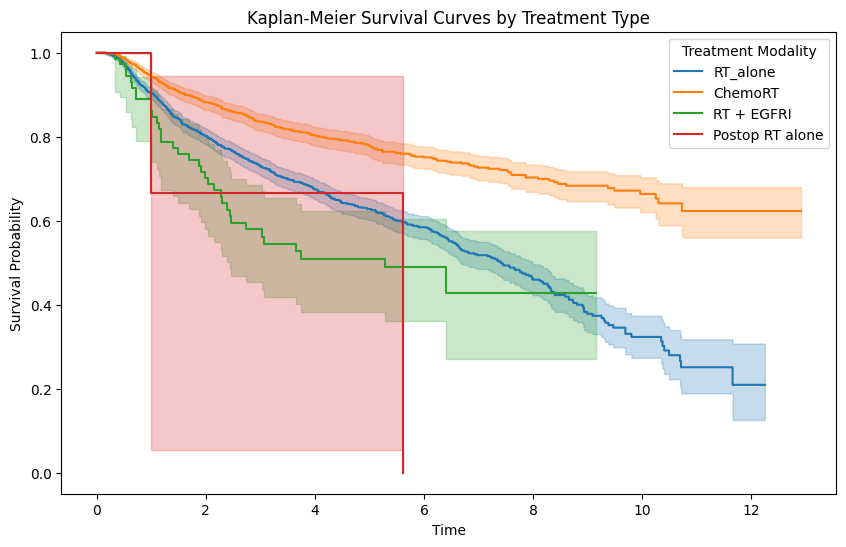

Log-rank test between RT_alone and ChemoRT: p-value = 0.00000
Log-rank test between RT_alone and RT + EGFRI: p-value = 0.03326
Log-rank test between RT_alone and Postop RT alone: p-value = 0.19501
Log-rank test between ChemoRT and RT + EGFRI: p-value = 0.00000
Log-rank test between ChemoRT and Postop RT alone: p-value = 0.02041
Log-rank test between RT + EGFRI and Postop RT alone: p-value = 0.46327


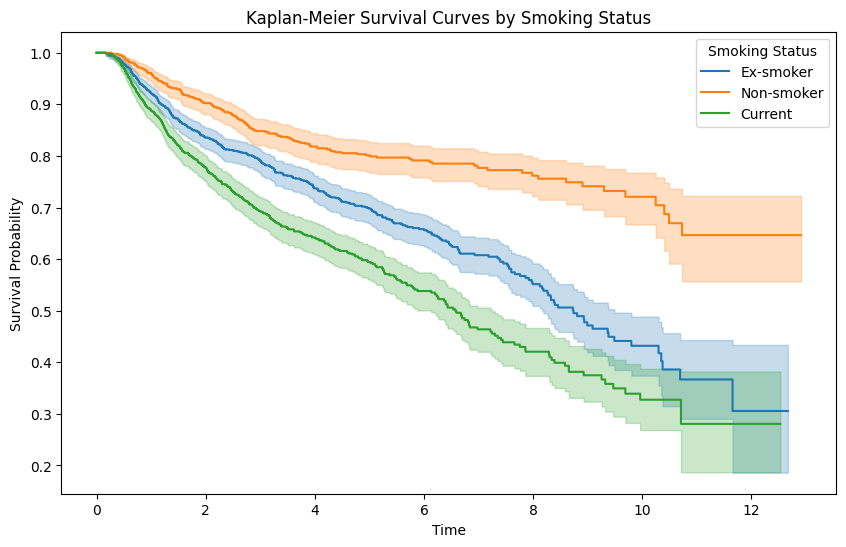

Log-rank test between Ex-smoker and Non-smoker: p-value = 0.00000
Log-rank test between Ex-smoker and Current: p-value = 0.00000
Log-rank test between Non-smoker and Current: p-value = 0.00000


In [3]:
# Build and Evaluate Models
# 1. Kaplan-Meier Analysis ------------------

kmf = KaplanMeierFitter()

# A. Kaplan-Meier Survival Curves by Tx Modality 
plt.figure(figsize=(10, 6))
for group in df_subset['Tx Modality'].unique():
    group_data = df_subset[df_subset['Tx Modality'] == group]
    kmf.fit(group_data['Survival_Time'], event_observed=group_data['Event'], label=group)
    kmf.plot()

plt.title("Kaplan-Meier Survival Curves by Treatment Type")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title='Treatment Modality')
plt.show()

# Log-rank test for Tx Modality
tx_groups = df_subset['Tx Modality'].unique()
for i in range(len(tx_groups)):
    for j in range(i + 1, len(tx_groups)):
        group1 = df_subset[df_subset['Tx Modality'] == tx_groups[i]]
        group2 = df_subset[df_subset['Tx Modality'] == tx_groups[j]]
        logrank_result = logrank_test(group1['Survival_Time'], group2['Survival_Time'], 
                                      event_observed_A=group1['Event'], event_observed_B=group2['Event'])
        # Print the log-rank test p-value to check for significant differences
        print(f"Log-rank test between {tx_groups[i]} and {tx_groups[j]}: p-value = {logrank_result.p_value:.5f}")



#----------------

# B. Kaplan-Meier Survival Curves by Smoking Status 
# Exclude Unknown to maintain meaningful comparisons in Smoking Status analysis
df_smoking = df_subset[df_subset['Smoking Status'] != 'unknown']

plt.figure(figsize=(10, 6))
for group in df_smoking['Smoking Status'].unique():
    group_data = df_smoking[df_smoking['Smoking Status'] == group]
    kmf.fit(group_data['Survival_Time'], event_observed=group_data['Event'], label=group)
    kmf.plot()

plt.title("Kaplan-Meier Survival Curves by Smoking Status")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title='Smoking Status')
plt.show()

# Log-rank test for Smoking Status
smoking_groups = df_smoking['Smoking Status'].unique()
for i in range(len(smoking_groups)):
    for j in range(i + 1, len(smoking_groups)):
        group1 = df_smoking[df_smoking['Smoking Status'] == smoking_groups[i]]
        group2 = df_smoking[df_smoking['Smoking Status'] == smoking_groups[j]]
        logrank_result = logrank_test(group1['Survival_Time'], group2['Survival_Time'], 
                                      event_observed_A=group1['Event'], event_observed_B=group2['Event'])
        # Print the log-rank test p-value to check for significant differences
        print(f"Log-rank test between {smoking_groups[i]} and {smoking_groups[j]}: p-value = {logrank_result.p_value:.5f}")





In [4]:
# # 2. Cox Proportional Hazards Regression
from sklearn.preprocessing import LabelEncoder

# Encode 'Sex' as numeric (Male = 1, Female = 0)
label_encoder = LabelEncoder()
df_subset['Sex'] = label_encoder.fit_transform(df_subset['Sex'])

# Replace 'na' with NaN (Not a Number) in the dataframe
df_subset.replace('na', pd.NA, inplace=True)
# print(df_subset.isna().sum())


# Drop rows with missing values in key columns
df_subset = df_subset.dropna(subset=['Survival_Time', 'Event', 'Age', 'Sex', 'Smoking PY'])

# Subset only relevant columns for the Cox model (no need for other columns)
df_subset_cox = df_subset[['Survival_Time', 'Event', 'Age', 'Sex', 'Smoking PY']].copy()  # Adjust to include only necessary columns


# Verify the columns are numeric and properly encoded
# print(df_subset[['Age', 'Sex', 'Smoking PY']].head()) 


# Create age bins as per cox recommendation
bins = [0, 30, 40, 50, 60, 70, 80, 90, 100]  # Adjust bin edges as needed
labels = ['0-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df_subset_cox.loc[:, 'Age_binned'] = pd.cut(df_subset_cox['Age'], bins=bins, labels=labels, right=False)
# Map the binned age categories to numeric values
age_bin_mapping = {
    '0-30': 1,
    '31-40': 2,
    '41-50': 3,
    '51-60': 4,
    '61-70': 5,
    '71-80': 6,
    '81-90': 7,
    '91-100': 8
}
df_subset_cox.loc[:, 'Age_binned_numeric'] = df_subset_cox['Age_binned'].map(age_bin_mapping)

# Drop the 'Age_binned' column after creating the 'Age_binned_numeric' column
df_subset_cox.drop(columns=['Age_binned'], inplace=True)
print(df_subset_cox.head())



# Covariates - select 3 
covariates = ['Age_binned_numeric', 'Sex', 'Smoking PY']
covariates = ['Age_binned', 'Sex', 'Smoking PY']

cph = CoxPHFitter()
# cph.fit(df_subset_cox[['Survival_Time', 'Event'] + covariates], duration_col='Survival_Time', event_col='Event')
cph.fit(df_subset_cox, duration_col='Survival_Time', event_col='Event')

# Print Cox model summary
cph.print_summary()

# validate
cph.check_assumptions(df_subset_cox, p_value_threshold=0.05)



   Survival_Time  Event   Age  Sex  Smoking PY Age_binned_numeric
0       1.317808      1  62.6    0        50.0                  5
1       1.520548      1  87.3    1        25.0                  7
2       2.126027      0  49.9    1        15.0                  3
3       5.791781      0  72.3    1        30.0                  6
4       9.512329      0  59.7    0         0.0                  4


<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7793.13
         time fit was run = 2025-03-15 03:06:27 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
Age                 0.03      1.04      0.01            0.01            0.06                1.01                1.06
Sex                -0.06      0.94      0.08           -0.21            0.09                0.81                1.10
Smoking PY          0.01      1.01      0.00            0.01            0.01                1.01                1.01
Age_binned_numeric  0.02      1.02      0.11           -0.19            0.23                0.83                1.26

                    cmp to     z      p  -log2(p)
covariate                                        
Age                   0.00  3.17 <0.005      9.34
Sex                   0.00 -0.78   0.43      1.20
Smoking PY            0.00 11.25 <0.005     95.09
Age_binned_numeric    0.00  0.22   0.83      0.27
---
Concordance = 0.65
Partial AIC = 15594.26
log-likelihood ratio test = 356.11 on 4 df
-log2(p) of ll-ratio test = 249.40

Proportional hazard assumption looks okay.


[]

In [ ]:
# 3. Random Survival Forests (RSF)
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

rsf_cols = ['Age', 'Sex', 'Smoking PY', 'ECOG PS', 'Stage', 'Smoking Status', 'Event', 'Survival_Time']

# Filter the dataset to only include the necessary columns
df_rsf_subset = df_subset[rsf_cols].copy()

# Apply Label Encoding to 'ECOG PS'
df_rsf_subset['ECOG PS'] = label_encoder.fit_transform(df_rsf_subset['ECOG PS'])
df_rsf_subset['Stage'] = df_rsf_subset['Stage'].fillna('Unknown')

print(df_rsf_subset.head())
print(df_rsf_subset.dtypes)
# encoder = OneHotEncoder()
# X_encoded = encoder.fit_transform(df_rsf_subset)  # Transform the dataset

# One-hot encode categorical variables like 'Stage', 'Sex', and 'Smoking Status'
df_sub_encoded = pd.get_dummies(df_rsf_subset, columns=['Stage', 'Smoking Status'], drop_first=True)
print(df_sub_encoded.head())
print(df_sub_encoded.head())
print(df_sub_encoded.isnull().sum())
# df_sub_encoded = df_sub_encoded.astype(int)

# Ensure that there are no missing values
# print(df_sub_encoded.isnull().sum())
# print(df_subset['ECOG PS'].unique())
# print(df_subset['Stage'].unique())  # Make sure it only contains valid stage levels
# print(df_subset['Smoking Status'].unique())

# Convert boolean columns to integers (0 or 1)
# df_sub_encoded = df_sub_encoded.astype(int)
# print(df_sub_encoded.head())

# # Prepare data for RSF
# X = df_sub_encoded[['Age', 'Sex', 'Smoking PY', 'ECOG PS'] + 
#                     [col for col in df_sub_encoded.columns if col.startswith('Smoking_Status')] + 
#                     [col for col in df_sub_encoded.columns if col.startswith('Stage')]]

print(df_sub_encoded.dtypes)

X = df_sub_encoded.drop(columns=['Event', 'Survival_Time'])  # Drop survival outcome columns

y = Surv.from_dataframe('Event', 'Survival_Time', df_rsf_subset)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RSF model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
rsf.fit(X_train, y_train)

# Perform permutation importance
result = permutation_importance(rsf, X_train, y_train, n_repeats=15, random_state=42)

# Create a DataFrame to display importance values
feature_importance = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean", "importances_std")
    },
    index=X.columns,
).sort_values(by="importances_mean", ascending=False)

# Sort by importances_mean
feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Comparison of Models (C-Index)
# Calculate C-index for RSF
c_index_rsf = concordance_index_censored(y_test['Event'], y_test['Survival_Time'], rsf.predict(X_test))[0]

# Assuming you have a Cox model (cph) for comparison
c_index_cox = cph.concordance_index_

print(f"Cox Proportional Hazards C-index: {c_index_cox:.3f}")
print(f"Random Survival Forest C-index: {c_index_rsf:.3f}")





    Age  Sex  Smoking PY  ECOG PS Stage Smoking Status  Event  Survival_Time
0  62.6    0        50.0        0   IVB      Ex-smoker      1       1.317808
1  87.3    1        25.0        3     I      Ex-smoker      1       1.520548
2  49.9    1        15.0        2   IVA      Ex-smoker      0       2.126027
3  72.3    1        30.0        2   IVA      Ex-smoker      0       5.791781
4  59.7    0         0.0        0   IVB     Non-smoker      0       9.512329
Age               float64
Sex                 int64
Smoking PY        float64
ECOG PS             int64
Stage              object
Smoking Status     object
Event               int64
Survival_Time     float64
dtype: object
    Age  Sex  Smoking PY  ECOG PS  Event  Survival_Time  Stage_I  Stage_IB  \
0  62.6    0        50.0        0      1       1.317808    False     False   
1  87.3    1        25.0        3      1       1.520548     True     False   
2  49.9    1        15.0        2      0       2.126027    False     False   
3  7